<div style="font-family:verdana;font-size:3.5rem;text-align:center;">
    Multi-Label Text Classification
</div>

<h1 style="font-family:verdana;"> Necessary Packages </h1>

In [1]:
%pip install contractions --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 5.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import kagglehub
import warnings
import os
import re
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import contractions
import xgboost as xgb
import random
import numpy as np
from wordcloud import WordCloud
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier,ClassifierChain
from sklearn.model_selection import train_test_split
from functools import partial
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    hamming_loss, 
    accuracy_score, 
    f1_score, 
    precision_score, 
    recall_score, 
    confusion_matrix,
)

In [3]:
tqdm.pandas()

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [6]:
sns.set_theme(style="darkgrid", palette="pastel")

<h1 style="font-family:verdana;"> Reproducibility </h1>


In [7]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

<h1 style="font-family:verdana;"> Data Loading </h1>


In [8]:
path = "/kaggle/input/multilabel-classification-dataset"

In [9]:
dtrain = pd.read_csv(os.path.join(path, "train.csv"))
dtest = pd.read_csv(os.path.join(path, "test.csv"))

<h1 style="font-family:verdana;"> Explanatory Data Analysis (EDA) </h1>

<h2 style="font-family:verdana;"> Basic EDA </h2>

#### Examine the number of rows and column in the dataset

In [10]:
rows, columns = dtrain.shape
print(f"The train set contains {rows} rows and {columns} columns")

The train set contains 20972 rows and 9 columns


In [11]:
rows, columns = dtest.shape
print(f"The test set contains {rows} rows and {columns} columns")

The test set contains 8989 rows and 3 columns


<div class="alert alert-block alert-info" style="font-size:16px; font-family:verdana; line-height: 1.7em;">
    📌 The test set doesn't contain any labels as it was part of a competition so we will proceed with only the training set.
</div>

#### Examine the head and the tail of the dataset

In [12]:
dtrain.head()

ID                                              TITLE  \
0   1        Reconstructing Subject-Specific Effect Maps   
1   2                 Rotation Invariance Neural Network   
2   3  Spherical polyharmonics and Poisson kernels fo...   
3   4  A finite element approximation for the stochas...   
4   5  Comparative study of Discrete Wavelet Transfor...   

                                            ABSTRACT  Computer Science  \
0    Predictive models allow subject-specific inf...                 1   
1    Rotation invariance and translation invarian...                 1   
2    We introduce and develop the notion of spher...                 0   
3    The stochastic Landau--Lifshitz--Gilbert (LL...                 0   
4    Fourier-transform infra-red (FTIR) spectra o...                 1   

   Physics  Mathematics  Statistics  Quantitative Biology  \
0        0            0           0                     0   
1        0            0           0                     0   
2        0            1           0                     0   
3        0            1           0                     0   
4        0            0           1                     0   

   Quantitative Finance  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

In [13]:
dtrain.tail()

ID                                              TITLE  \
20967  20968  Contemporary machine learning: a guide for pra...   
20968  20969  Uniform diamond coatings on WC-Co hard alloy c...   
20969  20970  Analysing Soccer Games with Clustering and Con...   
20970  20971  On the Efficient Simulation of the Left-Tail o...   
20971  20972   Why optional stopping is a problem for Bayesians   

                                                ABSTRACT  Computer Science  \
20967    Machine learning is finding increasingly bro...                 1   
20968    Polycrystalline diamond coatings have been g...                 0   
20969    We present a new approach for identifying si...                 1   
20970    The sum of Log-normal variates is encountere...                 0   
20971    Recently, optional stopping has been a subje...                 0   

       Physics  Mathematics  Statistics  Quantitative Biology  \
20967        1            0           0                     0   
20968        1            0           0                     0   
20969        0            0           0                     0   
20970        0            1           1                     0   
20971        0            1           1                     0   

       Quantitative Finance  
20967                     0  
20968                     0  
20969                     0  
20970                     0  
20971                     0

- Description of each column in the dataset

| Column                | Description                                              |
| --------------------- | -------------------------------------------------------- |
| ID                   | A unique ID identifying each paper (row) in the dataset  |
| TITLE                | The paper's title                                        |
| ABSTRACT             | The paper's abstract                                     |
| Computer Science     | Binary label indicating whether the paper belongs to the Computer Science field or not |
| Physics              | Binary label indicating whether the paper belongs to the Physics field or not |
| Mathematics          | Binary label indicating whether the paper belongs to the Mathematics field or not |
| Statistics           | Binary label indicating whether the paper belongs to the Statistics field or not |
| Quantitative Biology | Binary label indicating whether the paper belongs to the Quantitative Biology field or not |
| Quantitative Finance | Binary label indicating whether the paper belongs to the Quantitative Finance field or not |

#### Examining the different column types

In [14]:
dtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20972 non-null  int64 
 1   TITLE                 20972 non-null  object
 2   ABSTRACT              20972 non-null  object
 3   Computer Science      20972 non-null  int64 
 4   Physics               20972 non-null  int64 
 5   Mathematics           20972 non-null  int64 
 6   Statistics            20972 non-null  int64 
 7   Quantitative Biology  20972 non-null  int64 
 8   Quantitative Finance  20972 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.4+ MB


<div class="alert alert-block alert-info" style="font-size:16px; font-family:verdana; line-height: 1.7em;">
    📌 All columns' types are correct
</div>

#### Checking for missing values

In [15]:
dtrain.isna().sum()

ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64

<div class="alert alert-block alert-info" style="font-size:16px; font-family:verdana; line-height: 1.7em;">
    📌 No missing values
</div>

#### Examining basic statistics about the individuals columns

In [16]:
dtrain.describe()

ID  Computer Science       Physics   Mathematics  \
count  20972.000000      20972.000000  20972.000000  20972.000000   
mean   10486.500000          0.409784      0.286716      0.267881   
std     6054.239259          0.491806      0.452238      0.442866   
min        1.000000          0.000000      0.000000      0.000000   
25%     5243.750000          0.000000      0.000000      0.000000   
50%    10486.500000          0.000000      0.000000      0.000000   
75%    15729.250000          1.000000      1.000000      1.000000   
max    20972.000000          1.000000      1.000000      1.000000   

         Statistics  Quantitative Biology  Quantitative Finance  
count  20972.000000          20972.000000          20972.000000  
mean       0.248236              0.027990              0.011873  
std        0.432000              0.164947              0.108317  
min        0.000000              0.000000              0.000000  
25%        0.000000              0.000000              0.000000  
50%        0.000000              0.000000              0.000000  
75%        0.000000              0.000000              0.000000  
max        1.000000              1.000000              1.000000

### Checking for duplicates

In [17]:
dtrain.duplicated().sum()

0

<div class="alert alert-block alert-info" style="font-size:16px; font-family:verdana; line-height: 1.7em;">
    📌 There are no duplicates
</div>

<h2 style="font-family:verdana;"> Visualization </h2>


#### Frequencies of the individual labels

In [18]:
ID_COL = "ID"
FEATURES = ["TITLE", "ABSTRACT"]
TARGET_COLS = [col for col in dtrain.columns if col not in [ID_COL] + FEATURES]

Text(0.5, 0, 'Labels')

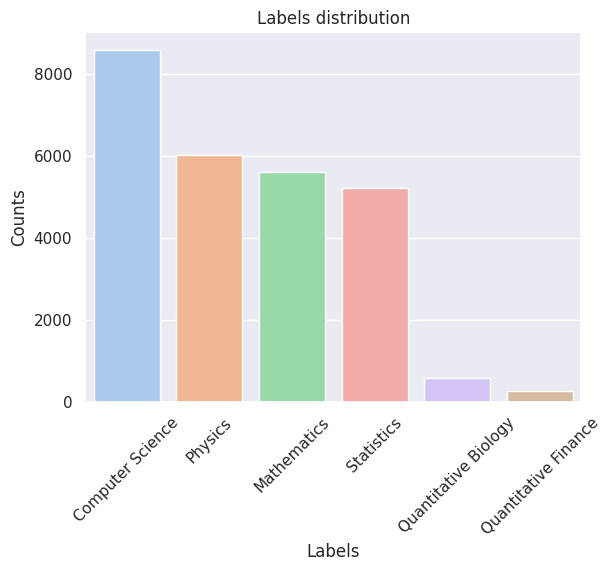

In [19]:
labels_counts = dtrain[TARGET_COLS].sum(axis=0)
labels, counts = labels_counts.index, labels_counts.values
ax = sns.barplot(x=labels, y=counts)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title("Labels distribution")
ax.set_ylabel("Counts")
ax.set_xlabel("Labels")

<div class="alert alert-block alert-info" style="font-size:16px; font-family:verdana; line-height: 1.7em;">
    📌 The topics <b>Quantitative Biology</b> and <b>Quantative Finance</b> are under-represented.
</div>

#### Co-occurance between the different topics

<Axes: >

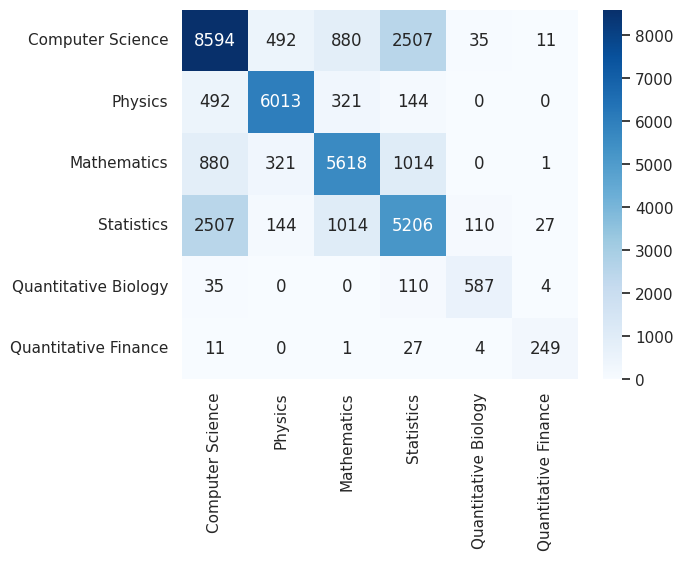

In [20]:
X = dtrain[TARGET_COLS].values
X = X.T @ X
sns.heatmap(X, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

#### Normalized co-occurence,plot frequencies instead of counts to not be misleaded by the imbalance in the data

<Axes: >

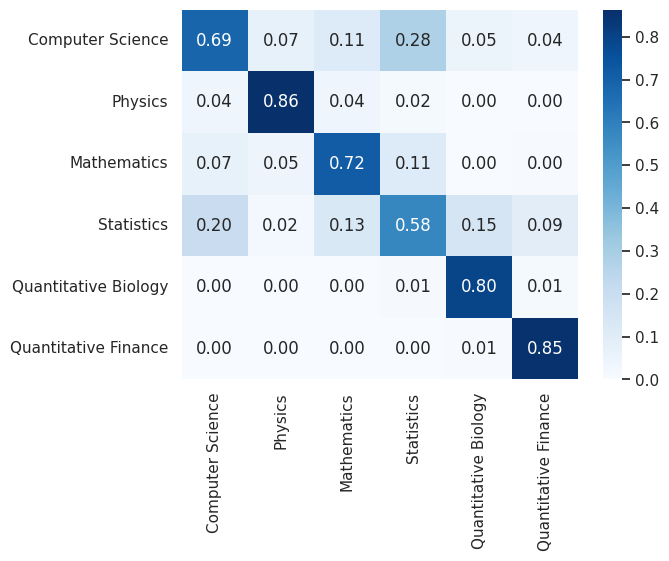

In [21]:
X = X / X.sum(axis=1)
sns.heatmap(X, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)

<div class="alert alert-block alert-info" style="font-size:16px; font-family:verdana; line-height: 1.7em;">
    📌 The topics <b>Computer Science</b> and <b>Statistics</b> are the topics that occurs the most together.<br/>
    📌 The other topics that occurs often together include : 
        <ul>
            <li>Computer Science and mathematics</li>
            <li>Statistics and mathematics</li>
            <li>Statistics and Quantitative Biology</li>
            <li>Statistics and Quantitative Finance</li>
        </ul>
</div>

#### Number of labels per row

<Axes: >

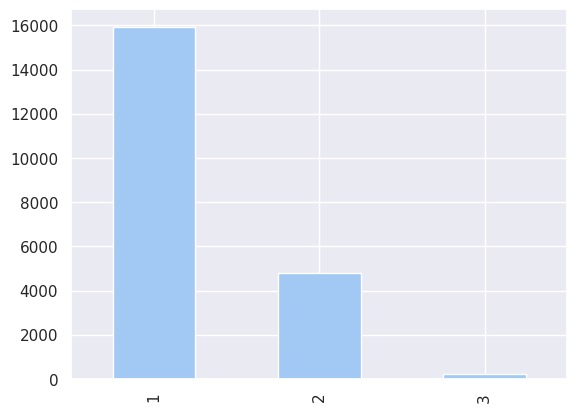

In [22]:
dtrain[TARGET_COLS].sum(axis=1).value_counts().sort_index().plot(kind="bar")

<div class="alert alert-block alert-info" style="font-size:16px; font-family:verdana; line-height: 1.7em;">
    📌 Most of the rows belong to only one or two topics and few to three different topics
</div>

#### Documents length

In [23]:
dtrain['title_len'] = dtrain['TITLE'].apply(lambda x: len(x.split()))
dtrain['abstract_len'] = dtrain['ABSTRACT'].apply(lambda x: len(x.split()))

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='title_len', ylabel='Count'>

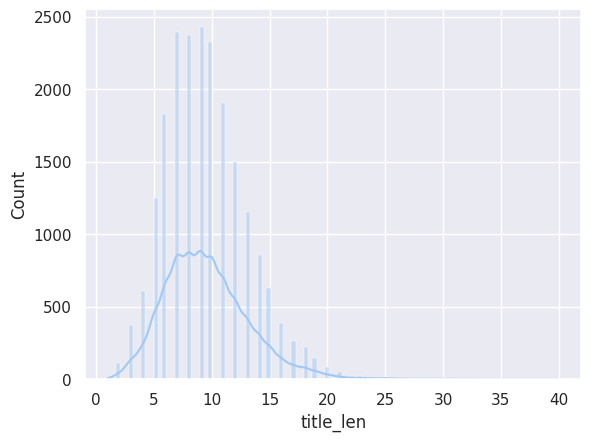

In [24]:
sns.histplot(dtrain['title_len'], kde=True)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='abstract_len', ylabel='Count'>

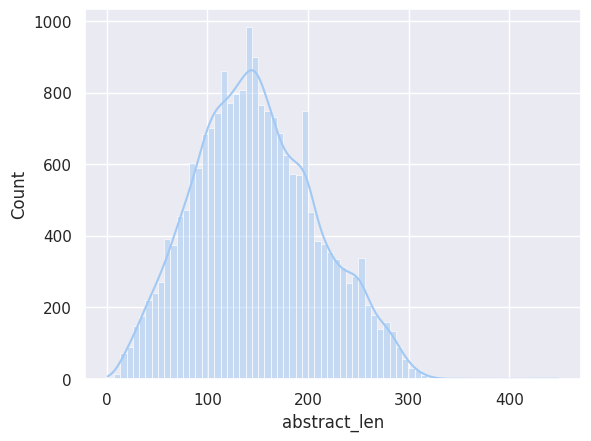

In [25]:
sns.histplot(dtrain['abstract_len'], kde=True)

<h2 style="font-family:verdana;"> Text Visualization </h2>

In [26]:
def plot_wordcloud(
    df : pd.DataFrame,
    label : str,
    ax : plt.Axes = None
) -> plt.Axes:
    
    df = df[df[label] == 1] # Filter rows with the label
    df = df[FEATURES] # Keep only the features columns

    text = df.apply(lambda x: " ".join(x), axis=1).str.cat(sep=" ") # Concatenate the features columns

    wc = WordCloud(width=800, height=400, background_color="black", colormap="viridis").generate(text)

    if ax is None:
        _, ax = plt.subplots()

    ax.imshow(wc)
    ax.axis("off")
    ax.set_title(f"Wordcloud for label: {label}", fontsize=30)

    return ax

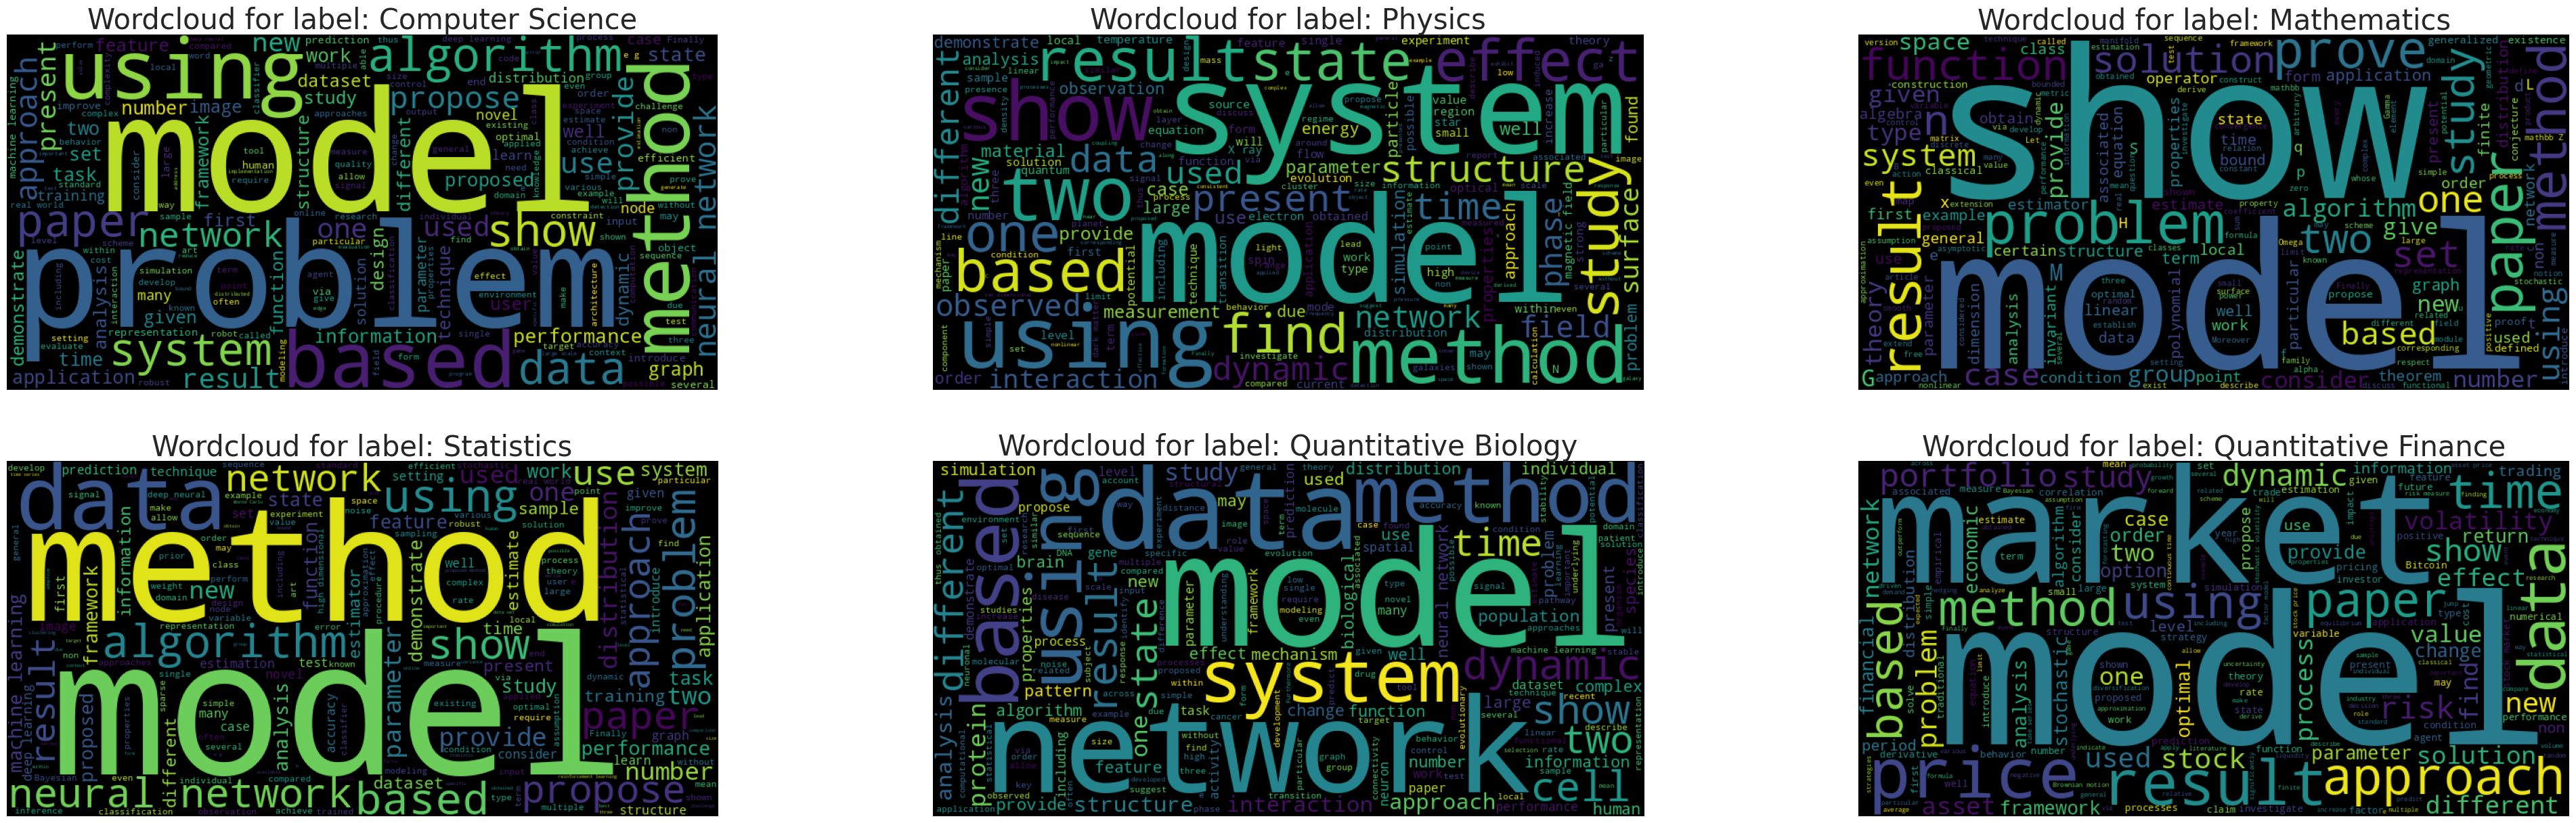

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(50, 15))

i = 0

for row in axes:
    for cell in row:
        label = TARGET_COLS[i]
        plot_wordcloud(dtrain, label, cell)
        i += 1

<h2 style="font-family:verdana;"> Preprocessing &amp; Text Cleaning </h2>

#### Examining random titles and abstracts from the dataset

In [28]:
for title in dtrain['TITLE'].sample(10):
    print(title)

Dynamic Layer Normalization for Adaptive Neural Acoustic Modeling in Speech Recognition
Susceptibility Propagation by Using Diagonal Consistency
The Robot Routing Problem for Collecting Aggregate Stochastic Rewards
Probability, Statistics and Planet Earth, I: Geotemporal covariances
Counting the number of metastable states in the modularity landscape: Algorithmic detectability limit of greedy algorithms in community detection
Sublogarithmic Distributed Algorithms for Lovász Local lemma, and the Complexity Hierarchy
Holography and Koszul duality: the example of the $M2$ brane
Maximal polynomial modulations of singular integrals
PULSEDYN - A dynamical simulation tool for studying strongly nonlinear chains
Variational Bayesian Inference For A Scale Mixture Of Normal Distributions Handling Missing Data


In [29]:
for title in dtrain['ABSTRACT'].sample(10):
    print(title)

  We analyze the clustering problem through a flexible probabilistic model that
aims to identify an optimal partition on the sample X 1 , ..., X n. We perform
exact clustering with high probability using a convex semidefinite estimator
that interprets as a corrected, relaxed version of K-means. The estimator is
analyzed through a non-asymptotic framework and showed to be optimal or
near-optimal in recovering the partition. Furthermore, its performances are
shown to be adaptive to the problem's effective dimension, as well as to K the
unknown number of groups in this partition. We illustrate the method's
performances in comparison to other classical clustering algorithms with
numerical experiments on simulated data.

  The contribution of $O^{2-}$ ions to antiferromagnetism in
$La_{2-x}Ae_xCuO_4$ ($Ae = Sr, Ba)$ is highly sensitive to doped holes. In
contrast, the contribution of $Cu^{2+}$ ions to antiferromagnetism in
$Nd_{2-x}Ce_xCuO_{4+y}$ is much less sensitive to doped electrons. T

<div class="alert alert-block alert-info" style="font-size:16px; font-family:verdana; line-height: 1.7em;">
    📌 We notice the existance of many latex (between $$).
</div>

#### Text Cleaning steps : 

When dealing with text data especially when dealing with small datasets or when we are planning to use simple machine leanrning models\
we usually rely on many Normalization and Text Cleaning steps some of them maybe manual or dataset-specific to educe the vocabulary's\
size as much as possible,this helps in :

1. Reducing the required computational power needed allowing the training to be conducted using simple ML Algorithms.
2. Reduce overfitting by removing noise. 

#### Most popular text cleaning/normalization techniques and how they transform a given sentence : 

Example : 

> "Hey @JohnDoe! 😊 Can't believe we're going to the park this evening! www.example.com #Excited 🚀"

| **Step**                     | **Description**                                                                                   | **Transformed Sentence**                                                                                     |
|-------------------------------|---------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------|
| **1. Lowercasing**            | Converts all characters to lowercase.                                                            | "hey @johndoe! 😊 can't believe we're going to the park this evening! www.example.com #excited 🚀"          |
| **2. Removing punctuations and numbers** | Removes punctuation marks (e.g., `!`, `?`, `.`) and numbers.                                  | "hey johndoe 😊 cant believe were going to the park this evening wwwexamplecom excited 🚀"                  |
| **3. Removing extra spaces**  | Replaces multiple spaces with a single space.                                                    | "hey johndoe 😊 cant believe were going to the park this evening wwwexamplecom excited 🚀"                  |
| **4. Handling urls, mentions and hashtags** | Replaces URLs, mentions, and hashtags with placeholders like `<URL>`, `<MENTION>`, `<HASHTAG>`. | "hey <MENTION> 😊 cant believe were going to the park this evening <URL> <HASHTAG> 🚀"                      |
| **5. Handling Emojis & emoticons** | Replaces emojis and emoticons with their text descriptions or placeholders.                       | "hey <MENTION> [smiley_face] cant believe were going to the park this evening <URL> <HASHTAG> [rocket]"    |
| **6. Remove contractions**    | Expands contractions into their full form (e.g., can't $\to$ can not).                                                       | "hey <MENTION> [smiley_face] cannot believe we are going to the park this evening <URL> <HASHTAG> [rocket]" |
| **7. Handling abbreviations** | Replaces abbreviations with their full forms (e.g., "e.g." → "for example").                     | "hey <MENTION> [smiley_face] cannot believe we are going to the park this evening <URL> <HASHTAG> [rocket]" |
| **8. Removing stop-words**    | Removes common stop-words like "the", "is", "are", etc.                                          | "hey <MENTION> [smiley_face] cannot believe going park evening <URL> <HASHTAG> [rocket]"                   |
| **9. Stemming and lemmatization** | Reduces words to their root form (e.g., "going" → "go").                                            | "hey <MENTION> [smiley_face] cannot believe go park evening <URL> <HASHTAG> [rocket]"                      |
| **10. Tokenization**          | Splits the sentence into individual tokens (words, emojis, placeholders, etc.).                  | `["hey", "<MENTION>", "[smiley_face]", "cannot", "believe", "go", "park", "evening", "<URL>", "<HASHTAG>", "[rocket]"]` |


In [30]:
class Processor:

    def __init__(self):

        self.stopwords = set(nltk.corpus.stopwords.words("english"))
        self.stemmer = nltk.stem.SnowballStemmer("english")

    def __call__(self, text : str) -> str:

        text = text.lower() # Lowercase
        text = text.replace('-', ' ') # Replace hyphens with spaces
        text = contractions.fix(text) # Expand contractions, for example don't -> do not
        text = re.sub(r"\$.*?\$", "", text) # Replace LaTeX equations
        text = re.sub(r"[^a-zA-Z0-9\s]", " ", text) # Remove special characters
        text = re.sub(r"\d+", " ", text) # Remove digits
        text = re.sub(r"\s+", " ", text) # Remove extra whitespaces
        text = nltk.word_tokenize(text) # Tokenize
        text = [word for word in text if word not in self.stopwords] # Remove stopwords
        text = [self.stemmer.stem(word) for word in text if word] # Stem words
        text = " ".join(text)

        return text

In [31]:
processor = Processor()
processor(dtrain['TITLE'].iloc[9])

'fail predict outbreak potenti presenc natur boost immun'

In [32]:
dtrain['PROCESSED_TITLE'] = dtrain['TITLE'].progress_apply(processor)
dtrain['PROCESSED_ABSTRACT'] = dtrain['ABSTRACT'].progress_apply(processor)
dtrain['PROCESSED_TEXT'] = dtrain['PROCESSED_TITLE'] + " " + dtrain['PROCESSED_ABSTRACT']

  0%|          | 0/20972 [00:00<?, ?it/s]

  0%|          | 0/20972 [00:00<?, ?it/s]

In [33]:
def get_vocab(docs : pd.Series) -> set:

    vocab = set()

    for doc in tqdm(docs):
        vocab.update(doc.split())

    return vocab

In [34]:
vocab = get_vocab(dtrain['PROCESSED_TEXT'])
print(f"The vocabulary contains {len(vocab)} unique words.")

  0%|          | 0/20972 [00:00<?, ?it/s]

The vocabulary contains 35373 unique words.


<h1 style="font-family:verdana;"> Data splitting </h1>

In [35]:
X = dtrain['PROCESSED_TEXT']
y = dtrain[TARGET_COLS]

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

print(f"Train set contains {len(X_train)} samples")
print(f"Validation set contains {len(X_val)} samples")

Train set contains 14680 samples
Validation set contains 6292 samples


<h1 style="font-family:verdana;"> Modeling &amp; Training </h1>

The way machine learning algorithms are adapted to multi-label tasks is by transforming them into either : 

1. A set of binary classification tasks.
2. A multi-class classification problem.

And this is can be acheived by : 

1. **Multi-output.**
2. **Classifier Chain.**
3. **Label Powerset.**

| **Method**            | **Description**                                                                                             | **Advantages**                                                                 | **Disadvantages**                                                                |
|------------------------|-----------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| **Multi-output**       | Creates a separate model for each label and trains them independently.                                    | - Simple to implement. <br/> - Scalable to many labels.                       | - Does not capture label dependencies. <br/> - Requires training multiple models.|
| **Classifier Chain**   | Creates a model for each label, using predictions from previous labels as additional features.            | - Captures label dependencies. <br/> - Can improve performance on correlated labels. | - Sensitive to the order of labels in the chain. <br/> - Computationally expensive. |
| **Label Powerset**     | Transforms the problem into a multi-class task by treating each unique combination of labels as a single class. | - Captures complex label dependencies. <br/> - Works well with small label sets. | - Can result in an explosion of classes for large label sets. <br/> - Imbalanced class distributions if combinations are rare. |


<h2 style="font-family:verdana;"> Utils </h2>

In [37]:
def evaluate_label_wise(
    y_true : pd.DataFrame,
    y_pred : pd.DataFrame,
    metrics : dict
) -> pd.DataFrame:

    results = []

    for label in y_true.columns:

        results.append({})
        
        for metric_name, metric in metrics.items():
            results[-1][metric_name] = metric(y_true[label], y_pred[label])

    results = pd.DataFrame(results, index=y_true.columns)
    results.loc['Mean'] = results.mean(axis=0)  

    return results

In [38]:
def evaluate(
    y_true : pd.DataFrame,
    y_pred : pd.DataFrame,
    metrics : dict
) -> pd.DataFrame:

    results = {}

    for metric_name, metric in metrics.items():
        results[metric_name] = metric(y_true, y_pred)

    return pd.Series(results)

In [39]:
def plot_confusion_matrices(
    y_true : pd.DataFrame,
    y_pred : pd.DataFrame,
): 
    fig, axes = plt.subplots(2, 3, figsize=(9, 5))

    for i, label in enumerate(y_true.columns):
        cm = confusion_matrix(y_true[label], y_pred[label])
        cm = cm / cm.sum(axis=1)[:, None]
        ax = sns.heatmap(cm, ax=axes[i//3, i%3], annot=True, fmt=".2f", cmap="Blues")
        ax.set_title(f"{label}")

    plt.tight_layout()

In [40]:
def plot_results(results : pd.DataFrame) -> None:

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    for i,metric in enumerate(results.columns):
        ax = axes[i//2, i%2]
        ax = sns.barplot(data=results, x=results.index, y=metric, ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    plt.tight_layout()

    return ax

In [41]:
def plot_cooccurrence_matrix(y : pd.DataFrame) -> None:
    X = y.T @ y
    X = X / X.sum(axis=1)
    sns.heatmap(X, annot=True, fmt=".2f", cmap="Blues", xticklabels=y.columns, yticklabels=y.columns)

<h2 style="font-family:verdana;"> Multioutput classifier </h2>


#### Building a pipeline that includes both feature extraction &amp; and modeling steps : 

| **Step**                     | **Description**                                                                                      |
|-------------------------------|------------------------------------------------------------------------------------------------------|
| **1. Vectorization (`TfidfVectorizer`)** | Converts raw text into numerical features using TF-IDF (Term Frequency-Inverse Document Frequency). |
| **2. Dimensionality Reduction (`TruncatedSVD`)** | Reduces the high-dimensional sparse TF-IDF matrix to a lower-dimensional dense representation.      |
| **3. Classification (`MultiOutputClassifier` with `XGBClassifier`)** | Performs multi-label classification, training one `XGBClassifier` per label.                              |


In [42]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("svd", TruncatedSVD(n_components=256)),
    ("classifier", MultiOutputClassifier(estimator=xgb.XGBClassifier()))
])

#### Training

In [43]:
model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('svd', TruncatedSVD(n_components=256)),
                ('classifier',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               device=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metric=None,
                                                               feature_ty...
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=None,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...)))])

#### Evaluation

##### Prediction

In [44]:
y_pred = model.predict(X_val)
y_pred = pd.DataFrame(y_pred, columns=y_val.columns)

##### Label Evaluation speratly
- evaluate each label speratly as its own independent binay classification task

In [45]:
metrics = {
    "accuracy" : accuracy_score,
    "precision" : precision_score,
    "recall" : recall_score,
    "f1_macro" : partial(f1_score, average="macro"),
}

In [46]:
moc_results = evaluate_label_wise(y_val, y_pred, metrics)
moc_results

accuracy  precision    recall  f1_macro
Computer Science      0.848379   0.786836  0.845659  0.843326
Physics               0.928322   0.915264  0.830878  0.910700
Mathematics           0.897807   0.847755  0.761098  0.866606
Statistics            0.879212   0.759234  0.731225  0.832916
Quantitative Biology  0.972505   0.666667  0.188482  0.639928
Quantitative Finance  0.991259   0.810811  0.384615  0.758664
Mean                  0.919580   0.797761  0.623660  0.808690

<Axes: ylabel='f1_macro'>

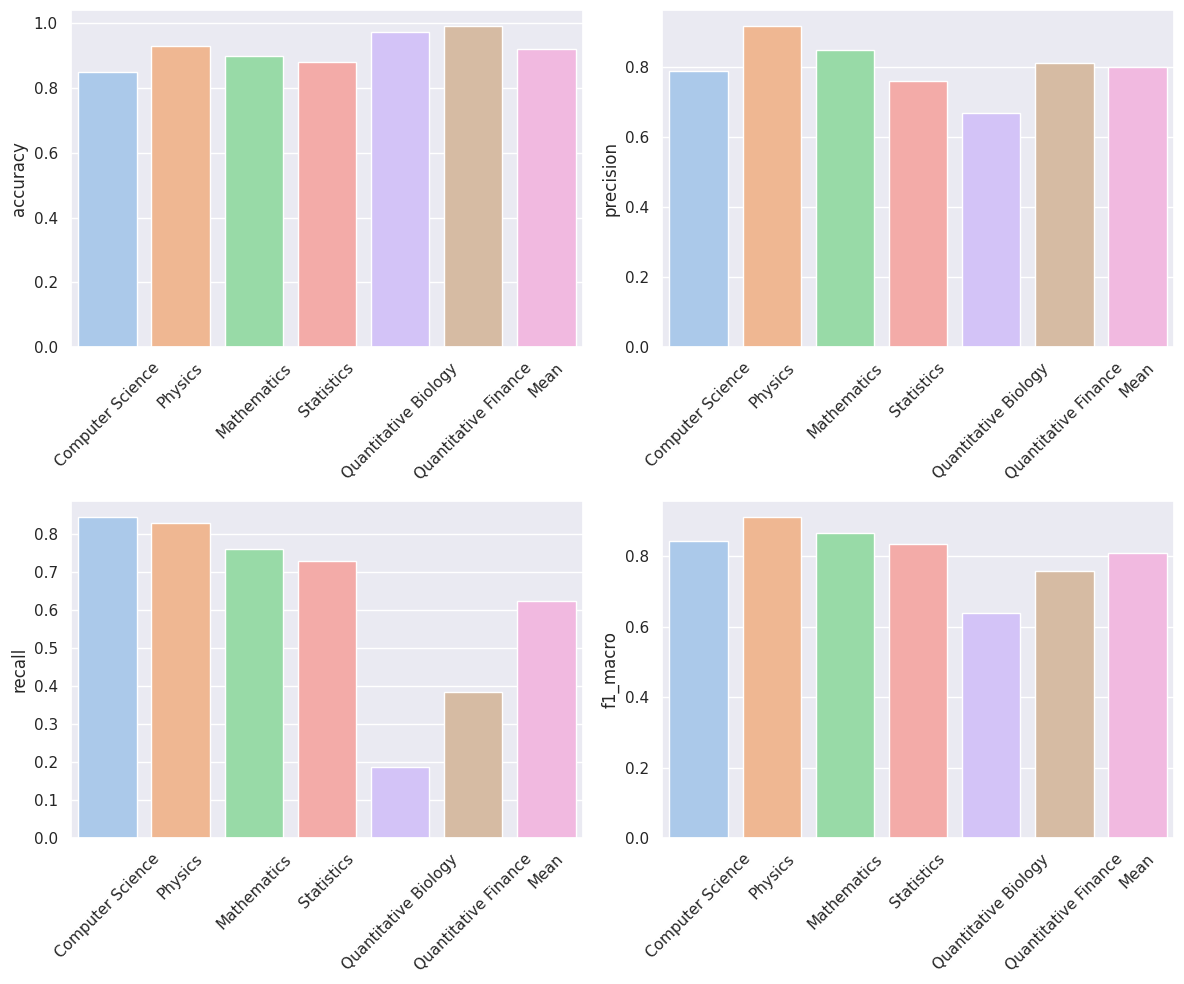

In [47]:
plot_results(moc_results)

<div class="alert alert-block alert-info" style="font-size:16px; font-family:verdana; line-height: 1.7em;">
    📌 As Expected the recaall for the labels <b>Quantitative Biology</b> and <b>Quantitative Finance</b> are low as they are under-represented in the dataset.
</div>

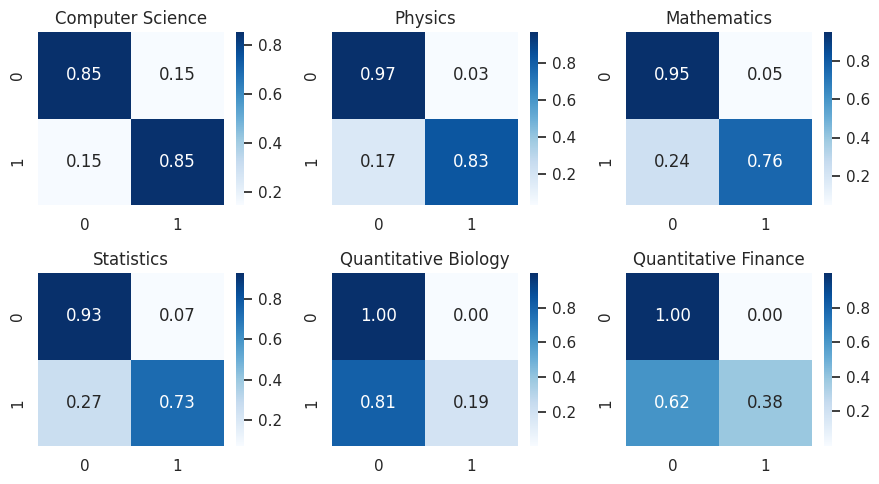

In [48]:
plot_confusion_matrices(y_val, y_pred)

##### Global Evaluation
this compares whole rows,for example in the case of accuracy it counts how many rows exaclty matches\
so results are expected to be low.

In [49]:
moc_results_2 = evaluate(y_val, y_pred, {
    "hamming_loss" : hamming_loss,
    "accuracy" : accuracy_score,
    "f1_macro" : partial(f1_score, average="macro"),
})

moc_results_2

hamming_loss    0.080420
accuracy        0.649078
f1_macro        0.674816
dtype: float64

##### Validation set labels co-occurance Vs Predictions labels co-occurence

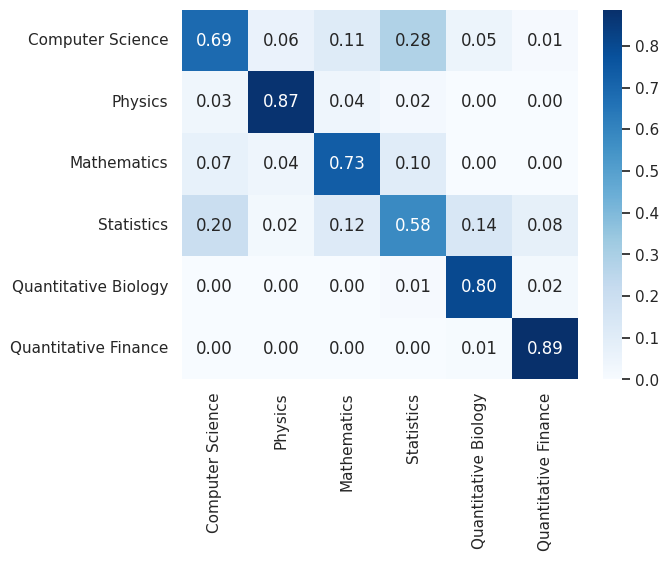

In [50]:
plot_cooccurrence_matrix(y_val)

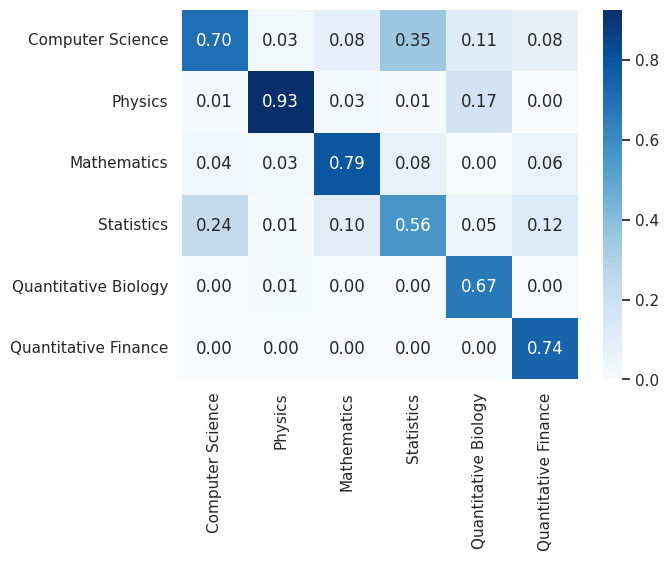

In [51]:
plot_cooccurrence_matrix(y_pred)

<div class="alert alert-block alert-info" style="font-size:16px; font-family:verdana; line-height: 1.7em;">
    📌 Our model is classifying some documents to occur in two different topics that usually don't occur together. <br/>
    📌 This is because each label is classified speratly and their co-occurence is not taking into account during training.
</div>

<h2 style="font-family:verdana;"> Classification chain </h2>

#### Building a pipeline that includes both feature extraction &amp; and modeling steps : 

- Keeping the same feature extraction,but replacing `MultiOutputClassifier` with `ClassifierChain`.

In [52]:
order = ['Physics', 'Computer Science', 'Statistics','Mathematics','Quantitative Biology', 'Quantitative Finance']

In [53]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("svd", TruncatedSVD(n_components=256)),
    ("classifier", ClassifierChain(
        base_estimator=xgb.XGBClassifier(),
        order=[TARGET_COLS.index(label) for label in order],
    ))
])

#### Training

In [54]:
model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('svd', TruncatedSVD(n_components=256)),
                ('classifier',
                 ClassifierChain(base_estimator=XGBClassifier(base_score=None,
                                                              booster=None,
                                                              callbacks=None,
                                                              colsample_bylevel=None,
                                                              colsample_bynode=None,
                                                              colsample_bytree=None,
                                                              device=None,
                                                              early_stopping_rounds=None,
                                                              enable_categorical=False,
                                                              eval_metric=None,
                                                              feature_typ...
                                                              importance_type=None,
                                                              interaction_constraints=None,
                                                              learning_rate=None,
                                                              max_bin=None,
                                                              max_cat_threshold=None,
                                                              max_cat_to_onehot=None,
                                                              max_delta_step=None,
                                                              max_depth=None,
                                                              max_leaves=None,
                                                              min_child_weight=None,
                                                              missing=nan,
                                                              monotone_constraints=None,
                                                              multi_strategy=None,
                                                              n_estimators=None,
                                                              n_jobs=None,
                                                              num_parallel_tree=None,
                                                              random_state=None, ...),
                                 order=[1, 0, 3, 2, 4, 5]))])

#### Evaluation

##### Prediction

In [55]:
y_pred = model.predict(X_val)
y_pred = pd.DataFrame(y_pred, columns=y_val.columns)

##### Label Evaluation speratly

In [56]:
cc_results = evaluate_label_wise(y_val, y_pred, metrics)
cc_results

accuracy  precision    recall  f1_macro
Computer Science      0.856961   0.793205  0.863344  0.852485
Physics               0.929593   0.919686  0.830878  0.912161
Mathematics           0.900032   0.858372  0.757593  0.868823
Statistics            0.876987   0.771137  0.696970  0.826168
Quantitative Biology  0.970915   0.541667  0.272251  0.673744
Quantitative Finance  0.990464   0.725000  0.371795  0.743356
Mean                  0.920825   0.768178  0.632139  0.812790

<Axes: ylabel='f1_macro'>

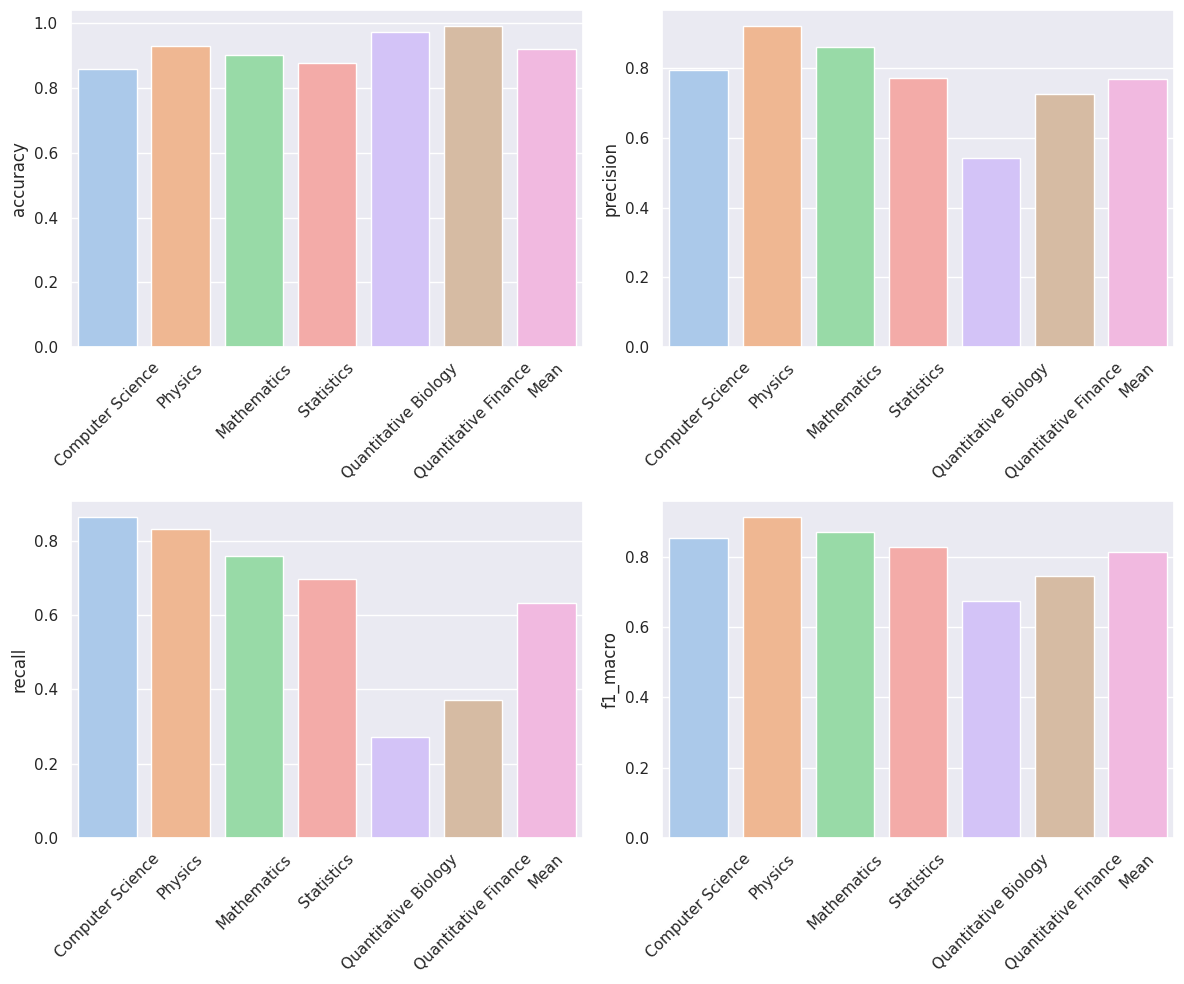

In [57]:
plot_results(cc_results)

<div class="alert alert-block alert-info" style="font-size:16px; font-family:verdana; line-height: 1.7em;">
    📌 Similar Average results across the different metrics. 
</div>

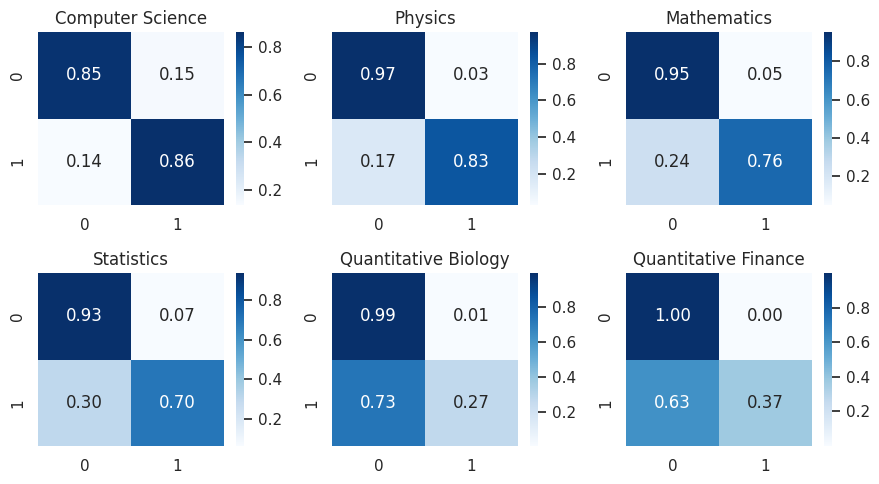

In [58]:
plot_confusion_matrices(y_val, y_pred)

##### Global Evaluation

In [59]:
cc_results_2 = evaluate(y_val, y_pred, {
    "hamming_loss" : hamming_loss,
    "accuracy" : accuracy_score,
    "f1_macro" : partial(f1_score, average="macro"),
})

cc_results_2

hamming_loss    0.079175
accuracy        0.674984
f1_macro        0.681789
dtype: float64

<div class="alert alert-block alert-info" style="font-size:16px; font-family:verdana; line-height: 1.7em;">
    📌 Slightly higher accuracy.
</div>

##### Validation set labels co-occurance Vs Predictions labels co-occurence

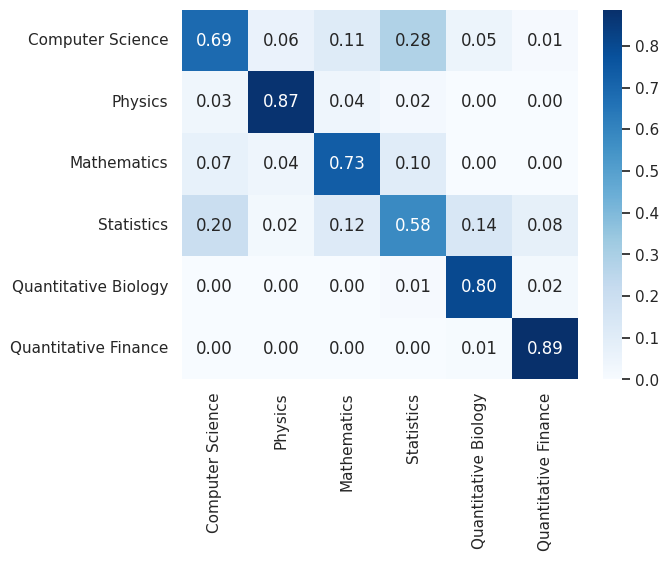

In [60]:
plot_cooccurrence_matrix(y_val)

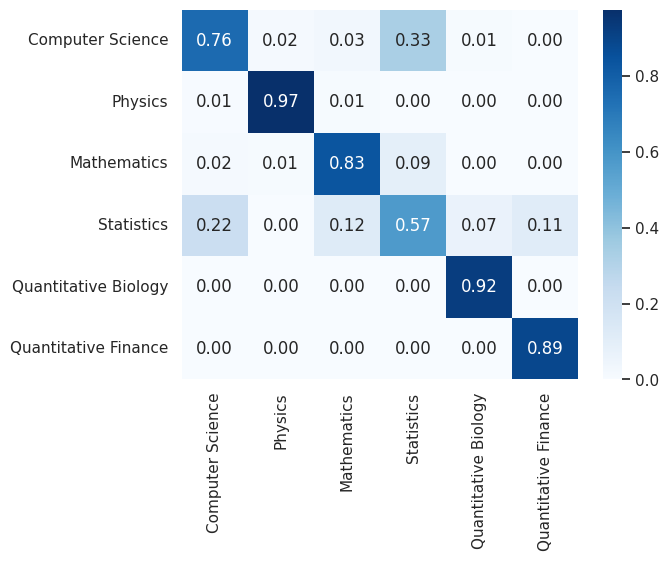

In [61]:
plot_cooccurrence_matrix(y_pred)

<div class="alert alert-block alert-info" style="font-size:16px; font-family:verdana; line-height: 1.7em;">
    📌 The model no longer mixes topics with lower co-occurence.<br/>
</div>

<h2 style="font-family:verdana;"> <b>MLSMOTE</b> for upsampling multi-label datasets </h2>

#### Calculate imbalance ratio per label

In [62]:
def irpl(y : pd.DataFrame) -> pd.Series:
    labels_count = y.sum(axis=0)
    return labels_count.max() / labels_count

In [63]:
irpls = irpl(y_train)
print(irpls)

Computer Science         1.000000
Physics                  1.460766
Mathematics              1.563236
Statistics               1.655640
Quantitative Biology    15.419192
Quantitative Finance    35.707602
dtype: float64


#### Get the labels that are considered under-represented (tail labels)

- $L_i$ is a tail label if its $IRPL$ is higher than the **average** $IRPL$.

In [64]:
tail_labels = irpls.index[irpls > irpls.mean()]
print(tail_labels)

Index(['Quantitative Biology', 'Quantitative Finance'], dtype='object')


#### MLSMOTE Complete implementation

1. Compute $IRPL$ for each label.
2. Determine tail labels.
3. Get top-k neighbors for each sample that belongs to at least one of the tail neighbors.
4. Compute synthetic samples

In [65]:
class MLSMOTE:

    def __init__(self,
        n_neighbors : int = 5,
        alpha_scale : float = 0.25,
    ) -> None:
        
        self.irpls = None
        self.tail_labels = None
        self.nn = None
        self.labels_count = None

        self.n_neighbors = n_neighbors
        self.alpha_scale = alpha_scale

    def _irpl(self, y : pd.DataFrame) -> pd.Series:
        labels_count = y.sum(axis=0)
        return labels_count.max() / labels_count
    
    def _tail_labels(self, y : pd.DataFrame) -> list[str]:
        irpls = self._irpl(y)
        return irpls.index[irpls > irpls.mean()].to_list()
    
    def _labels_count(self) -> dict:

        irpls = self.irpls
        p = irpls / irpls.sum()
        p = p ** -self.alpha_scale
        p = p / p.sum()
        p = p * len(y)
        p = p.astype(int)
        p = p[self.tail_labels].to_dict()

        return p

    def fit_resample(self, X : pd.DataFrame, y : pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
        
        ### Compute the IRPL for each label
        irpls = self._irpl(y)
        self.irpls = irpls

        ### Get the tail labels
        tail_labels = self._tail_labels(y)
        self.tail_labels = tail_labels

        ### Calculate the number of synthetic samples to generate for each tail label
        labels_count = self._labels_count()
        self.labels_count = labels_count

        ### Restrict X and y to instances with tail labels
        index = X.index[y[tail_labels].sum(axis=1) > 0]
        subset_X = X.loc[index].reset_index(drop=True)
        subset_y = y.loc[index].reset_index(drop=True)

        ### Get the neighbors for each sample in the subset
        nn = NearestNeighbors(n_neighbors=self.n_neighbors)
        self.nn = nn.fit(X)
        neighbors = nn.kneighbors(subset_X, return_distance=False)

        ### Generate synthetic samples
        X_synth = [X]
        y_synth = [y]

        for tail_label, count in labels_count.items():
            
            # 1- Pick random reference samples
            indices = np.arange(len(subset_X))
            indices = indices[subset_y[tail_label] == 1]
            reference_indices = np.random.choice(indices, count)

            # 2- Pick random neighbors of the reference samples
            random_neighbors = np.random.randint(1, self.n_neighbors, count)
            random_neighbors = neighbors[reference_indices, random_neighbors]

            # 3- Compute the difference between the reference samples and their neighbors
            gap = subset_X.iloc[reference_indices].values - X.iloc[random_neighbors].values

            # 4- Compute the synthetic samples features X
            ratio = np.random.rand(count, 1)
            X_new = subset_X.loc[reference_indices].values + ratio * gap
            X_new = pd.DataFrame(X_new, columns=subset_X.columns)

            # 5- Compute the synthetic samples labels y
            y_new = y.values[neighbors[reference_indices,:].flatten()]
            y_new = y_new.reshape(count, self.n_neighbors, subset_y.shape[1])
            y_new = y_new.sum(axis=1) > 0
            y_new = y_new.astype(int)
            y_new = pd.DataFrame(y_new, columns=subset_y.columns)

            # 6- Append the synthetic samples to the original dataset
            X_synth.append(X_new)
            y_synth.append(y_new)

        X_synth = pd.concat(X_synth)
        y_synth = pd.concat(y_synth)

        return X_synth, y_synth

#### Apply MLSMOTE

- To apply MLSMOTE `X` needs to be a matrix,i.e : text processed using `TfIdf`,so we need to seperate the feature extraction from the model.

In [66]:
feature_extractor = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("svd", TruncatedSVD(n_components=256)),
])

In [67]:
X_train_features = feature_extractor.fit_transform(X_train)
X_val_features = feature_extractor.transform(X_val)

In [68]:
mlsmote = MLSMOTE(alpha_scale=0.1)
X_train_resampled, y_train_resampled = mlsmote.fit_resample(pd.DataFrame(X_train_features, index=y_train.index), y_train)

- The new dataset have a higher number of samples

In [69]:
print(f"Train set contains {len(X_train_resampled)} samples")

Train set contains 20423 samples


- Examine the new labels distribution

In [70]:
print(y_train_resampled.sum())

Computer Science        9642
Physics                 7036
Mathematics             5701
Statistics              6611
Quantitative Biology    3870
Quantitative Finance    3118
dtype: int64


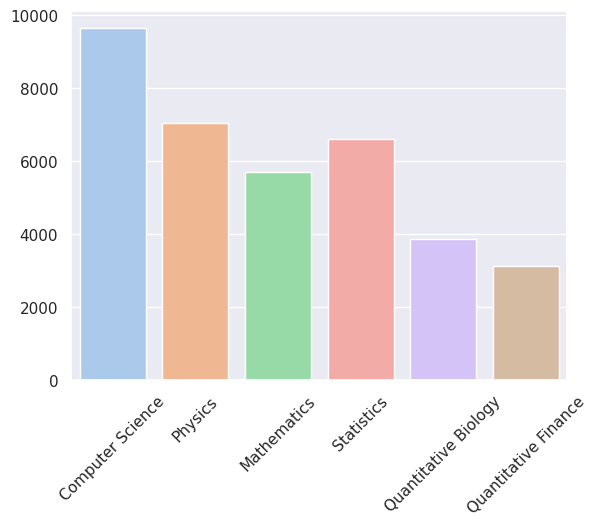

In [71]:
ax = sns.barplot(x=y_train_resampled.columns, y=y_train_resampled.sum())
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

- Re-calculate $IRPL$

In [72]:
irpls = irpl(y_train_resampled)
print(irpls)

Computer Science        1.000000
Physics                 1.370381
Mathematics             1.691282
Statistics              1.458478
Quantitative Biology    2.491473
Quantitative Finance    3.092367
dtype: float64


### Training

In [73]:
model = MultiOutputClassifier(estimator=xgb.XGBClassifier())

In [74]:
model.fit(X_train_resampled, y_train_resampled)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))

#### Evaluation

##### Prediction

In [75]:
y_pred = model.predict(X_val_features)
y_pred = pd.DataFrame(y_pred, columns=y_val.columns)

##### Label-Wise Evaluation

In [76]:
mlsmote_results = evaluate_label_wise(y_val, y_pred, metrics)
mlsmote_results

accuracy  precision    recall  f1_macro
Computer Science      0.848697   0.780292  0.859325  0.844243
Physics               0.924984   0.896793  0.839062  0.907366
Mathematics           0.895264   0.837716  0.762850  0.863886
Statistics            0.880324   0.762166  0.732543  0.834340
Quantitative Biology  0.972823   0.628205  0.256545  0.675213
Quantitative Finance  0.991100   0.761905  0.410256  0.764420
Mean                  0.918865   0.777846  0.643430  0.814911

<Axes: ylabel='f1_macro'>

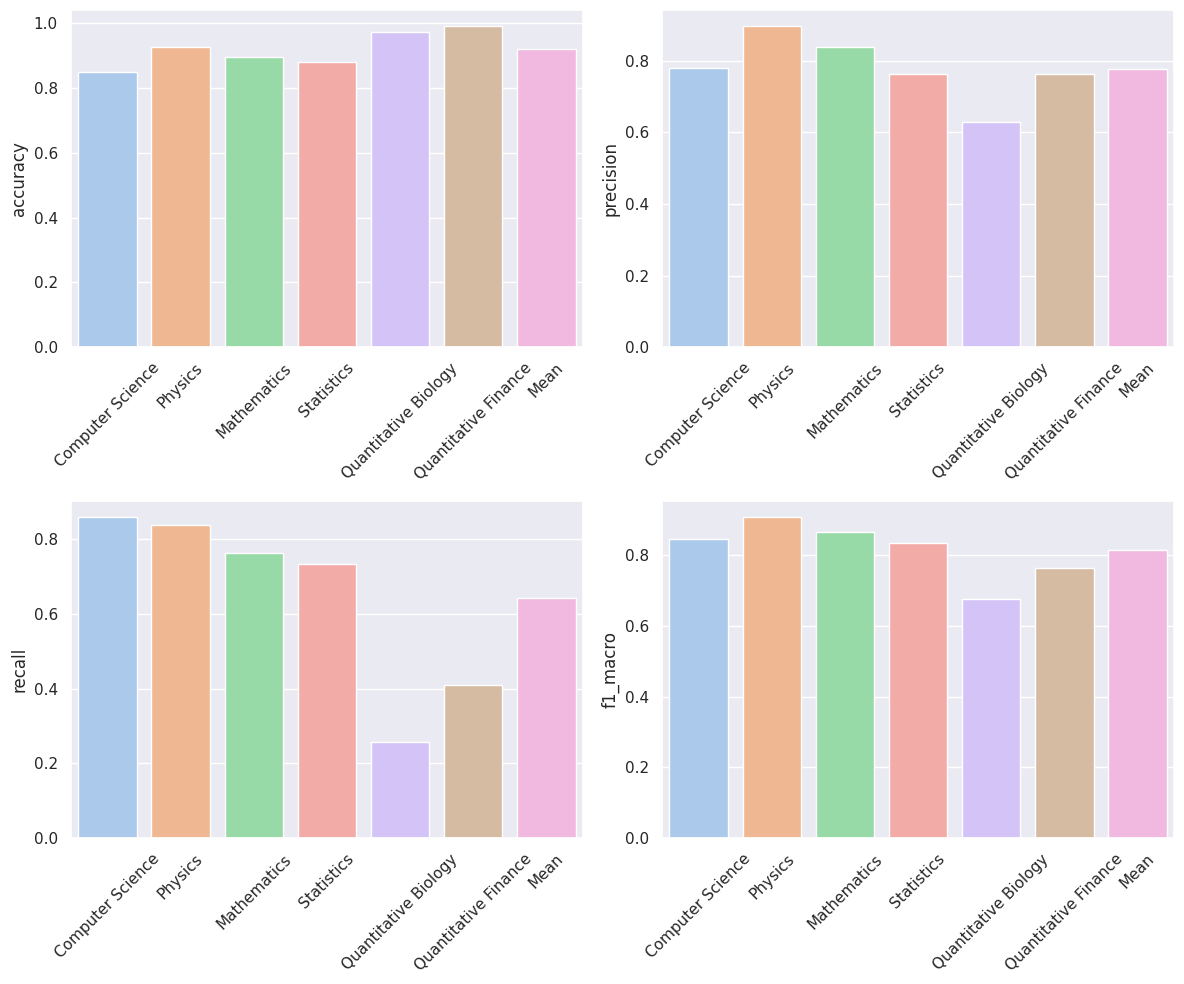

In [77]:
plot_results(mlsmote_results)

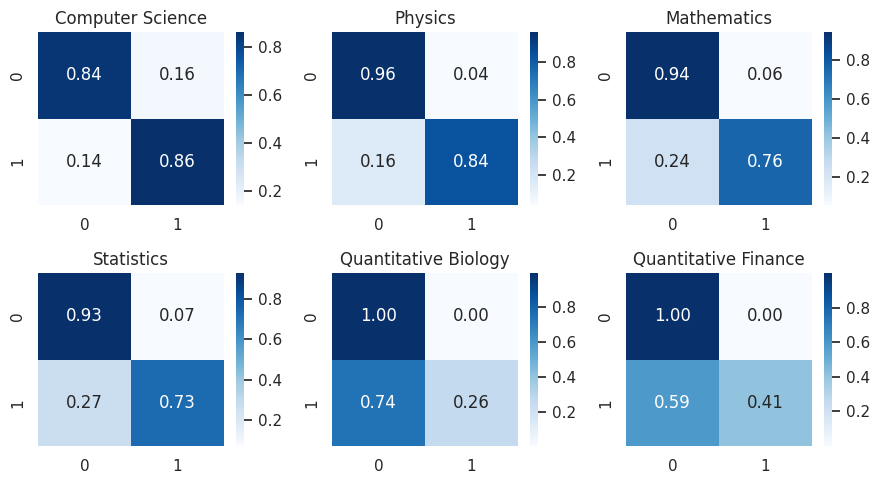

In [78]:
plot_confusion_matrices(y_val, y_pred)

##### Global Evaluation

In [79]:
mlsmote_results_2 = evaluate(y_val, y_pred, {
    "hamming_loss" : hamming_loss,
    "accuracy" : accuracy_score,
    "f1_macro" : partial(f1_score, average="macro"),
})

mlsmote_results_2

hamming_loss    0.081135
accuracy        0.645423
f1_macro        0.688018
dtype: float64

##### Validation set labels co-occurance Vs Predictions labels co-occurence

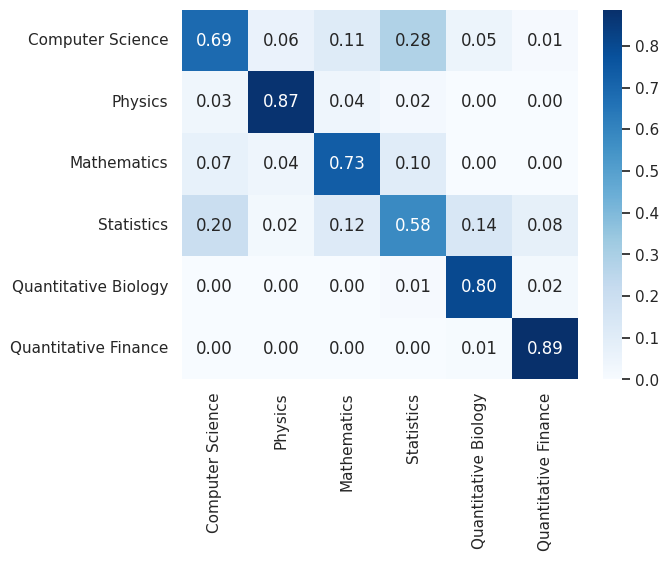

In [80]:
plot_cooccurrence_matrix(y_val)

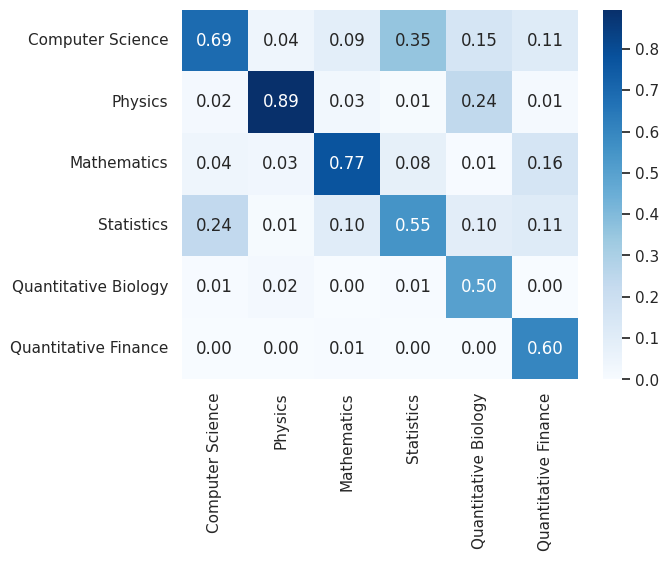

In [81]:
plot_cooccurrence_matrix(y_pred)

<div id="necessary_packages" >
    <h1 style="font-family:verdana;"> Comparison </h1>
</div>

In [82]:
cc_results['type'] = 'ClassifierChain'
moc_results['type'] = 'MultiOutputClassifier'
mlsmote_results['type'] = 'MOC_MLSMOTE'

results = pd.concat([cc_results, moc_results, mlsmote_results])
results.head()

accuracy  precision    recall  f1_macro             type
Computer Science      0.856961   0.793205  0.863344  0.852485  ClassifierChain
Physics               0.929593   0.919686  0.830878  0.912161  ClassifierChain
Mathematics           0.900032   0.858372  0.757593  0.868823  ClassifierChain
Statistics            0.876987   0.771137  0.696970  0.826168  ClassifierChain
Quantitative Biology  0.970915   0.541667  0.272251  0.673744  ClassifierChain

In [83]:
means = results[results.index == 'Mean']
means

accuracy  precision    recall  f1_macro                   type
Mean  0.920825   0.768178  0.632139  0.812790        ClassifierChain
Mean  0.919580   0.797761  0.623660  0.808690  MultiOutputClassifier
Mean  0.918865   0.777846  0.643430  0.814911            MOC_MLSMOTE

- F1 Score

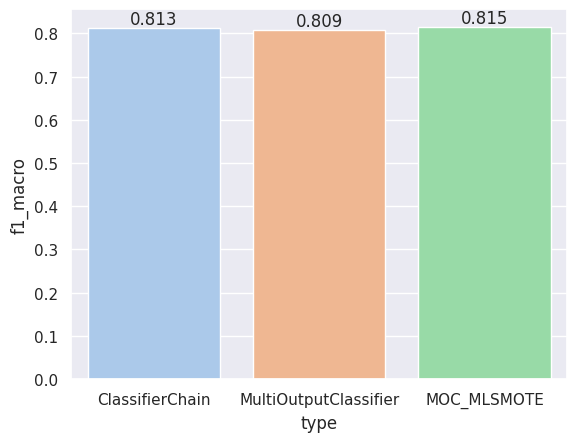

In [84]:
ax = sns.barplot(data=means, x="type", y="f1_macro")

for i in ax.containers:
    ax.bar_label(i,fmt='%.3f',label_type='edge')

- Accuracy

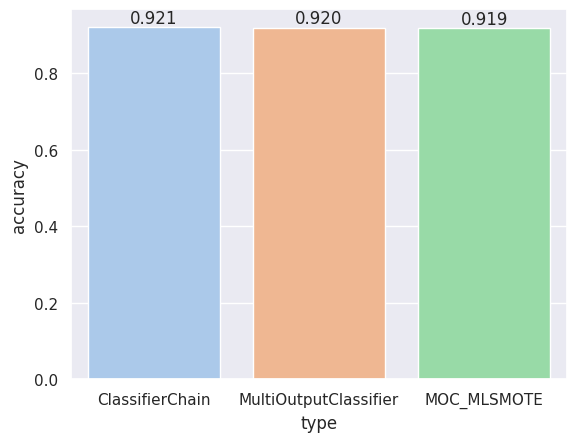

In [85]:
ax = sns.barplot(data=means, x="type", y="accuracy")

for i in ax.containers:
    ax.bar_label(i,fmt='%.3f',label_type='edge')

- Precision

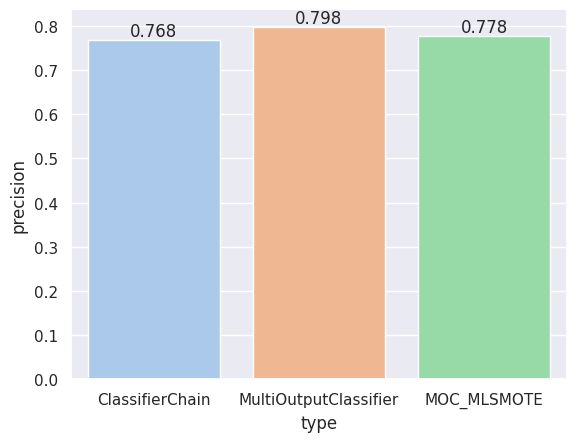

In [86]:
ax = sns.barplot(data=means, x="type", y="precision")

for i in ax.containers:
    ax.bar_label(i,fmt='%.3f',label_type='edge')

- Recall 

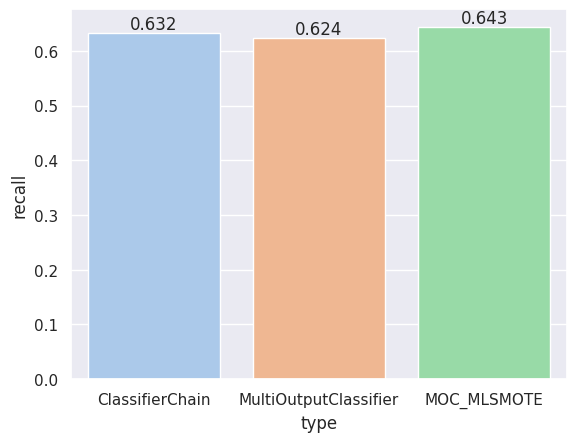

In [87]:
ax = sns.barplot(data=means, x="type", y="recall")

for i in ax.containers:
    ax.bar_label(i,fmt='%.3f',label_type='edge')

- Hamming Loss

In [88]:
moc_results_2 = moc_results_2.to_frame().transpose()
moc_results_2['type'] = 'MultiOutputClassifier'

cc_results_2 = cc_results_2.to_frame().transpose()
cc_results_2['type'] = 'ClassifierChain'

mlsmote_results_2 = mlsmote_results_2.to_frame().transpose()
mlsmote_results_2['type'] = 'MOC_MLSMOTE'

results_2 = pd.concat([cc_results_2, moc_results_2, mlsmote_results_2])
results_2.head()

hamming_loss  accuracy  f1_macro                   type
0      0.079175  0.674984  0.681789        ClassifierChain
0      0.080420  0.649078  0.674816  MultiOutputClassifier
0      0.081135  0.645423  0.688018            MOC_MLSMOTE

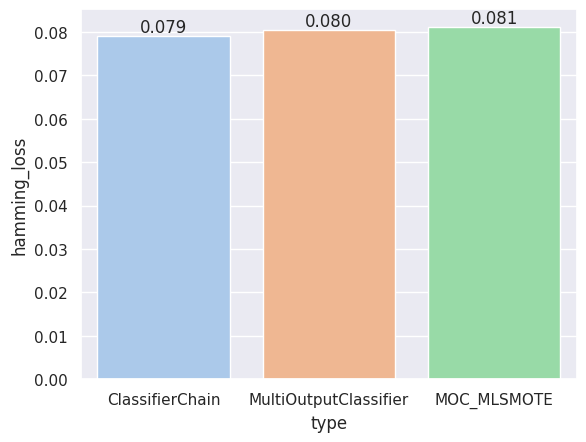

In [89]:
ax = sns.barplot(data=results_2, x='type', y="hamming_loss")

for i in ax.containers:
    ax.bar_label(i,fmt='%.3f',label_type='edge')

- Subset accuracy

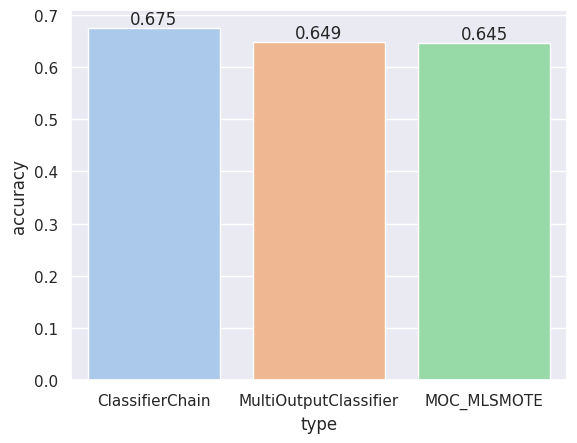

In [90]:
ax = sns.barplot(data=results_2, x='type', y="accuracy")

for i in ax.containers:
    ax.bar_label(i,fmt='%.3f',label_type='edge')

- F1 Score

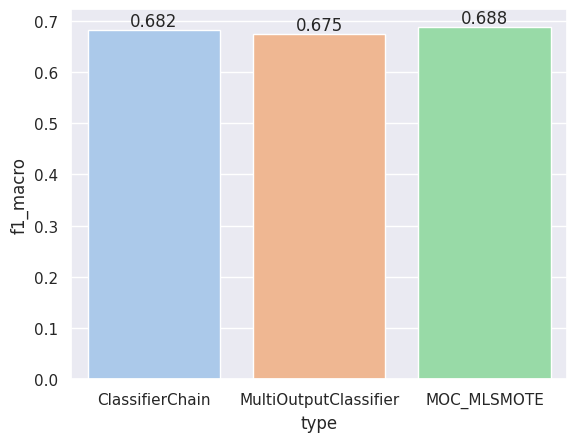

In [91]:
ax = sns.barplot(data=results_2, x='type', y="f1_macro")

for i in ax.containers:
    ax.bar_label(i,fmt='%.3f',label_type='edge')

<div class="alert alert-block alert-info" style="font-size:16px; font-family:verdana; line-height: 1.7em;">
    📌 Classifier Chain,highest in terms of subset accuracy and mean accuracy.<br/>
    📌 MOC + SMOTE,highest in terms of subset f1 score and mean f1 score (but not too different from CC).
</div>

<div id="necessary_packages" >
    <h1 style="font-family:verdana;"> Thank You :) </h1>
</div>